In [1]:
import random
import numpy as np
import torch
from tqdm import tqdm
import torch.nn as nn
from torch.optim import Adam
import matplotlib.pyplot as plt
from sklearn.datasets import make_swiss_roll

In [2]:
def sample_batch(batch_size, device="cuda"):
    data, _ = make_swiss_roll(batch_size, random_state=42)
    # operations to make it equal to the paper
    data = data[:, [2, 0]] / 10
    # flip the image vertically by inverting the rows in reverse order
    data = data * np.array([1, -1])
    return torch.from_numpy(data).to(device)

In [3]:
class MLP(nn.Module):
    def __init__(self, N=40, data_dim=2, hidden_dim=64):
        super(MLP, self).__init__()
        self.network_head = nn.Sequential(
            nn.Linear(data_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
        )
        self.network_tail = nn.ModuleList(
            [
                nn.Sequential(
                    nn.Linear(hidden_dim, hidden_dim),
                    nn.ReLU(),
                    nn.Linear(hidden_dim, data_dim * 2),
                )
                for t in range(N)
            ]
        )

    def forward(self, x, t):
        h = self.network_head(x)  # [batch_size, hidden_dim]
        # print(h.shape)
        tmp = self.network_tail[t](h)  # [batch_size, data_dim * 2]
        # print(tmp.shape)
        mu, h = torch.chunk(tmp, 2, dim=1)
        var = torch.exp(h)
        std = torch.sqrt(var)

        return mu, std

In [4]:
def plot(model, filename, device="cuda"):
    N = 5_000
    x0= sample_batch(N).to(device)
    samples = model.sample(N, device=device)
    
    fontsize=22
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 6))
    # Common x and y limits
    x_limits = (-2, 2)
    y_limits = (-2, 2)
    
    data = [
            [x0.cpu(), model.forward_process(x0, 20)[-1].cpu(), model.forward_process(x0, 40)[-1].cpu()],
            [samples[0], samples[20], samples[40]]
           ]
    titles = ['t=0','t=T/2', 't=T']
    
    for i in range(nrows):  # Iterate over rows
        for j in range(ncols):  # Iterate over columns
            colour = "b" if i == 0 else "r"
            if i == 0 and j == 0:
                ax[i,j].set_ylabel(r"$q\mathbf{x}^{(0..T)})$")
            if i == 1 and j == 0:
                ax[i,j].set_ylabel(r"$p\mathbf{x}^{(0..T)})$")
            ax[i,j].scatter(data[i][j][:, 0].data.cpu().numpy(), data[i][j][:, 1].data.cpu().numpy(), alpha=0.1, c= colour, s=4)
            ax[i,j].set_title(titles[j])
            ax[i,j].set_xlim(x_limits)
            ax[i,j].set_ylim(y_limits)
            plt.gca().set_aspect("equal")
    
    plt.tight_layout()
    plt.savefig(filename, bbox_inches="tight")
    plt.close()

In [5]:
class DiffusionModel():
    def __init__(self, T, model: nn.Module, dim=2, device = "cuda"):
        self.betas = (torch.sigmoid(torch.linspace(-18, 10, T)) * (3e-1 - 1e-5) + 1e-5).to(device)
        self.alphas = 1 - self.betas
        self.alphas_bar = torch.cumprod(self.alphas, dim=0)
        self.T = T
        self.model = model
        self.dim = dim

    def forward_process(self, x0, t):
        """
        param t: number of diffusion steps
        """
        assert t > 0, "should be greater than zero"
        t <= self.T, f"t should be lower or equal than {self.T}" 
        
        t = t - 1 # index start at zero
        mu = torch.sqrt(self.alphas_bar[t]) * x0
        std = torch.sqrt(1 - self.alphas_bar[t])
        epsilon = torch.randn_like(x0)
        xt = mu + epsilon * std  # data ~ N(mu, std)

        m1 = torch.sqrt(self.alphas_bar[t-1]) * self.betas[t] / (1 - self.alphas_bar[t])
        m2 = torch.sqrt(self.alphas[t]) * (1-self.alphas_bar[t-1]) / (1 - self.alphas_bar[t])
        mu_q = m1 * x0 + m2 * xt
        std_q = torch.sqrt( (1-self.alphas_bar[t-1]) / (1-self.alphas_bar[t]) * self.betas[t] )
        
        return mu_q, std_q, xt

    def reverse_process(self, xt, t):
        assert t > 0, "should be greater than zero"
        t <= self.T, f"t should be lower or equal than {self.T}"

        t = t - 1 # index start at zero
        mu, std = self.model(xt, t)
        epsilon = torch.randn_like(xt)
        return  mu, std, mu + epsilon * std # data ~ N(mu, std)

    def sample(self, batch_size, device="cuda"):
        noise = torch.randn(batch_size, self.dim).to(device)
        x = noise

        # adding the starting noise already makes the list composed of 41 elements (like in the paper)
        samples = [x]
        for t in range(self.T, 0, -1):
            # Edge effect of diffusione model (in the last step don't do anything)
            if not (t == 1):
                _, _, x = self.reverse_process(x, t)
            samples.append(x)

        return samples[:: -1] # reverse results in the list

    def get_loss(self, x0):
        """
        param x0: batch [batch_size, self.dim]
        """
        # sample t
        t = torch.randint(2, 40+1, (1,))
        mu_q , sigma_q, xt = self.forward_process(x0, t)
        mu_p, sigma_p,  xt_minus1 = self.reverse_process(xt.float(), t)
        # KL divergence for two gaussian distribution KL(q||p)
        KL = torch.log(sigma_p) -  torch.log(sigma_q) + (sigma_q**2 + (mu_q - mu_p)**2) / (2 * sigma_p**2)
        K_prime = - KL.mean() # we want to maximize K
        loss = -K_prime # should be minimized
        return loss

In [6]:
def train(diffusion_model, optimizer, batch_size, epochs, device="cuda"):

    training_loss = []
    for epoch in tqdm(range(epochs)):
        xO = sample_batch(batch_size).to(device)
        loss = diffusion_model.get_loss(xO)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        training_loss.append(loss.item())

        if epoch % 100 == 0 and epoch !=0:
            plt.plot(training_loss)
            plt.savefig(f"./train_figs/train_loss_epoch_{epoch}.png")
            plt.show()
            plot(diffusion_model, f"./train_figs/train_epoch_{epoch}.png")
    
    return training_loss

In [7]:
device = "cuda"
mlp_model = MLP(hidden_dim=128).to(device)
diff_model = DiffusionModel(40, mlp_model)
optimizer = Adam(mlp_model.parameters(), lr=1e-4)

 33%|█████████████████████████████████▋                                                                    | 99/300 [00:01<00:03, 58.83it/s]

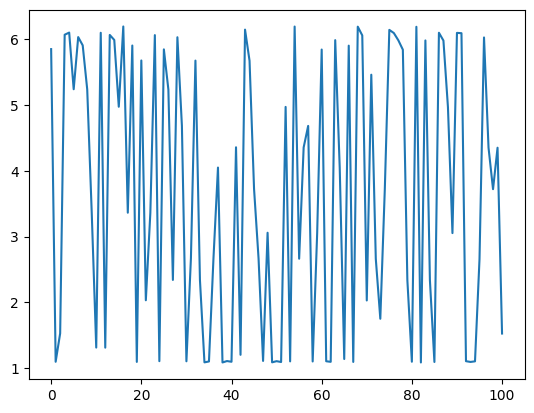

 65%|█████████████████████████████████████████████████████████████████▉                                   | 196/300 [00:05<00:01, 52.41it/s]

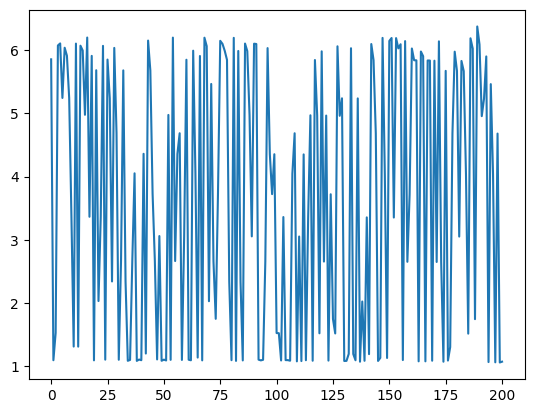

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:08<00:00, 36.23it/s]


[5.852924230158913,
 1.0960848855189442,
 1.5282992486572249,
 6.071790806208654,
 6.104364771562397,
 5.242489305778846,
 6.035954688642285,
 5.9103088664351375,
 5.240538582290569,
 3.3673198785641696,
 1.3122267830365157,
 6.101640155337791,
 1.311030581067908,
 6.068567707128297,
 5.992261970436526,
 4.976112668970294,
 6.1973380346751785,
 3.364058116261726,
 5.9075664496770806,
 1.0942250334456385,
 5.680226293643302,
 2.0317559268083043,
 3.3615870312798815,
 6.065909440105612,
 1.1053129052865802,
 5.848991006913078,
 5.237570704537504,
 2.341346702553256,
 6.033411651261009,
 4.685726942986885,
 1.1034974883167235,
 2.6721998953781787,
 5.6782607067023445,
 2.340401471876192,
 1.087213782840673,
 1.100707526539254,
 2.669871189448765,
 4.050823801003744,
 1.0855841956843908,
 1.1071666093598567,
 1.096191761886158,
 4.359349864546263,
 1.2019412532801974,
 6.149447424475666,
 5.675751479855469,
 3.726529329770638,
 2.6666247328271466,
 1.1088882593221712,
 3.059096176143422,
 

In [8]:
num_epochs = 300
train(diff_model, optimizer, 64_000, num_epochs)